## 0. Thiết lập môi trường & thư viện

Phần này chuẩn bị môi trường chạy cho toàn bộ pipeline:

- Import các thư viện xử lý dữ liệu và trực quan hóa  
- Cài đặt và tải dữ liệu NLTK phục vụ tiền xử lý văn bản (stopwords, tokenize, wordnet)  
- Cài đặt `transformers` để sử dụng mô hình BERT  
- Kiểm tra GPU và chọn thiết bị chạy phù hợp (CUDA nếu có)

**Kết quả mong đợi:** notebook sẵn sàng chạy các bước tiền xử lý, huấn luyện và suy luận với BERT.


In [ ]:

import re
import statistics as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Define device
device = 'cuda' if len(tf.config.experimental.list_physical_devices('GPU')) > 0 else 'cpu'
print(f"Using device: {device}")

Num GPUs Available:  1
Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## 1. Tải và khám phá tập dữ liệu

Phần này sử dụng `kagglehub` để tải trực tiếp bộ dữ liệu *Hate Speech and Offensive Language Dataset* từ Kaggle.

Sau khi tải xong, thư mục dữ liệu được liệt kê để:
- Xác nhận dữ liệu đã được tải thành công  
- Kiểm tra các file có trong bộ dữ liệu  
- Chuẩn bị cho bước đọc và tiền xử lý dữ liệu ở các phần tiếp theo

**Kết quả mong đợi:** đường dẫn tới thư mục dữ liệu và danh sách các file chứa trong đó.


In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)
print("Files in dataset directory:", os.listdir(path))

Using Colab cache for faster access to the 'hate-speech-and-offensive-language-dataset' dataset.
Path to dataset files: /kaggle/input/hate-speech-and-offensive-language-dataset
Files in dataset directory: ['labeled_data.csv']


## 2. Đọc và kiểm tra cấu trúc dữ liệu

Dữ liệu được đọc từ file CSV đã tải về và lưu vào DataFrame của pandas.

Ở bước này, thực hiện:
- Hiển thị một vài dòng đầu tiên để quan sát nội dung văn bản và nhãn
- Kiểm tra thông tin tổng quát của tập dữ liệu, bao gồm số lượng mẫu, số cột và kiểu dữ liệu
- Xác định các cột liên quan đến nhãn (*hate speech*, *offensive language*, *neither*) và cột văn bản (*tweet*)

**Kết quả mong đợi:** nắm rõ cấu trúc dữ liệu trước khi tiến hành tiền xử lý và xây dựng mô hình.


In [27]:
from IPython.display import display
data = pd.read_csv(path + '/labeled_data.csv')
print("dataset head:")
display(data.head())
print("dataset info:")
data.info()


dataset head:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


## 3. Làm sạch dữ liệu và chuẩn hóa nhãn

Ở bước này, tập dữ liệu được tinh gọn để chỉ giữ lại các thông tin cần thiết cho bài toán phân loại văn bản.

Các thao tác chính gồm:
- Loại bỏ các cột không dùng trực tiếp cho huấn luyện mô hình  
- Đổi tên cột nhãn về dạng thống nhất (`label`)  
- Ánh xạ nhãn số sang nhãn dạng chuỗi để dễ phân tích và diễn giải  
- Kiểm tra lại dữ liệu sau khi làm sạch và phân bố các lớp

**Kết quả mong đợi:** tập dữ liệu gọn nhẹ, rõ ràng, sẵn sàng cho bước tiền xử lý văn bản và huấn luyện mô hình.


In [28]:
data_cleaned = data.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])
data_cleaned.rename(columns = {'class':'label'}, inplace=True)

label_mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
data_cleaned['label'] = data_cleaned['label'].map(label_mapping)

print("Cleaned dataset head:")
print(data_cleaned.head())
print("Cleaned dataset info:")
data_cleaned.info()
print("Value counts for labels:")
print(data_cleaned['label'].value_counts())

Cleaned dataset head:
                label                                              tweet
0             neither  !!! RT @mayasolovely: As a woman you shouldn't...
1  offensive_language  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2  offensive_language  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3  offensive_language  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4  offensive_language  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  object
 1   tweet   24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB
Value counts for labels:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


## 4. Trực quan hóa phân bố nhãn

Biểu đồ cột được sử dụng để quan sát số lượng mẫu ở từng lớp nhãn trong tập dữ liệu.  
Bước này giúp đánh giá nhanh mức độ **cân bằng/không cân bằng** giữa các lớp, từ đó định hướng chiến lược huấn luyện và đánh giá mô hình.

**Kết quả mong đợi:** nhìn rõ lớp nào chiếm đa số và lớp nào ít hơn trong tập dữ liệu.


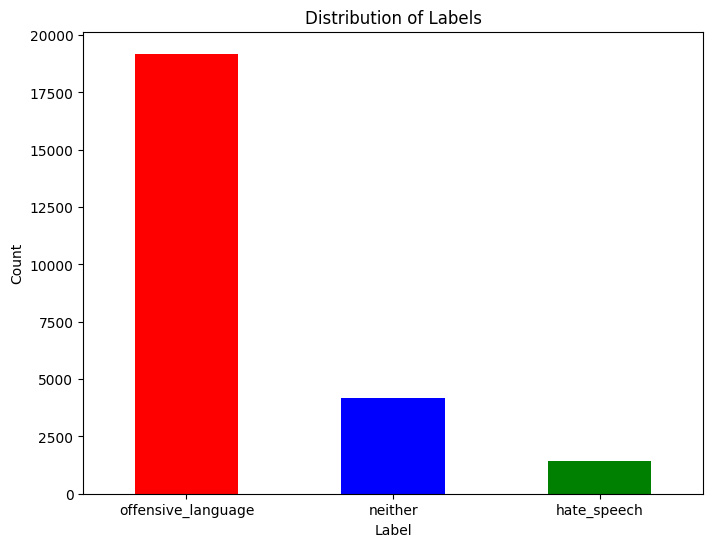

In [29]:
plt.figure(figsize=(8,6))
data_cleaned['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 5. Tiền xử lý văn bản (Text Preprocessing)

Dữ liệu tweet thường chứa nhiều thành phần gây nhiễu (URL, mention, hashtag, ký tự đặc biệt).  
Bước này chuẩn hóa văn bản để mô hình tập trung vào nội dung chính.

Các thao tác được áp dụng:
- Loại bỏ URL (link)  
- Loại bỏ mention (ví dụ: `@username`)  
- Loại bỏ hashtag (ví dụ: `#topic`)  
- Chuyển toàn bộ về chữ thường (lowercase)  
- Tokenize văn bản thành các từ  
- Lọc chỉ giữ token là chữ cái và loại bỏ stopwords tiếng Anh  
- Ghép token trở lại thành chuỗi để đưa vào pipeline huấn luyện

**Kết quả mong đợi:** cột `tweet` đã được làm sạch và đồng nhất định dạng trước khi đưa vào mô hình.


# 5.5. Chia tập Train/Test trước khi tăng cường dữ liệu

 Để tránh *data leakage*, tập dữ liệu được chia thành train và test **trước khi áp dụng data augmentation**.

 - Tập **train** sẽ được tăng cường dữ liệu và cân bằng nhãn  
 - Tập **test** được giữ nguyên từ dữ liệu gốc để đánh giá khách quan khả năng tổng quát hóa

 **Kết quả mong đợi:** tập test không bị ảnh hưởng bởi augmentation, giúp kết quả đánh giá đáng tin cậy.


In [ ]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(filtered_tokens)
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_text)

print('Data after cleaning:')
print(data_cleaned.head())



train_df, test_df = train_test_split(
    data_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=data_cleaned['label']
)

print("Train size:", len(train_df))
print("Test size :", len(test_df))
print("\nTrain label distribution:")
print(train_df['label'].value_counts())
print("\nTest label distribution:")
print(test_df['label'].value_counts())

Data after cleaning:
                label                                              tweet
0             neither  rt woman complain cleaning house amp man alway...
1  offensive_language  rt boy dats cold tyga dwn bad cuffin dat hoe p...
2  offensive_language  rt dawg rt ever fuck bitch start cry confused ...
3  offensive_language                                rt look like tranny
4  offensive_language  rt shit hear might true might faker bitch told ya



## 6. Tăng cường dữ liệu (Data Augmentation) trên tập huấn luyện

 Một số lớp (đặc biệt là *hate_speech*) có thể ít mẫu hơn, gây mất cân bằng nhãn.
 Để cải thiện khả năng học của mô hình với lớp thiểu số, áp dụng augmentation bằng **synonym replacement**
 dựa trên WordNet **chỉ trên tập train**.

 Quy trình:
 - Lọc các tweet thuộc lớp `hate_speech` trong tập train
 - Tạo thêm nhiều biến thể bằng cách thay thế ngẫu nhiên một từ bằng từ đồng nghĩa
 - Ghép các mẫu tăng cường vào **train_df** để tạo **train_augmented**

 **Kết quả mong đợi:** số lượng mẫu lớp `hate_speech` trong train tăng lên, trong khi test vẫn giữ nguyên.


Data after augmentation:
label
offensive_language    19190
hate_speech            5708
neither                4163
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels After Augmentation')

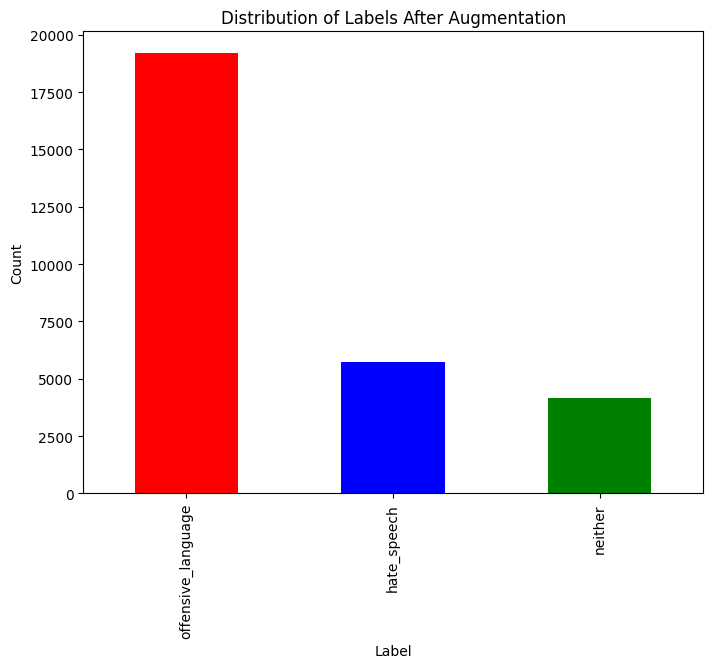

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def augment_text(text, num_augments=1):
    word = text.split()
    augment_text = []

    for i in range(num_augments):
        new_words = list(word)

        if not new_words:
            continue

        random_word_index = np.random.randint(0, len(new_words))
        random_word = new_words[random_word_index]

        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = np.random.choice(synonyms)
            new_words[random_word_index] = random_synonym

        augment_text.append(' '.join(new_words))
    return augment_text

hate_speech_train = train_df[train_df['label'] == 'hate_speech'].copy()

augment_samples = []
for _, row in hate_speech_train.iterrows():
    augmented_texts = augment_text(row['tweet'], num_augments=3)
    for aug_text in augmented_texts:
        augment_samples.append({
            'tweet': aug_text,
            'label': 'hate_speech'
        })

augment_df = pd.DataFrame(augment_samples)

train_augmented = pd.concat([train_df, augment_df], ignore_index=True)

print("Train data label distribution after augmentation:")
print(train_augmented['label'].value_counts())


print("Train data after augmentation:")
print(train_augmented['label'].value_counts())
plt.figure(figsize=(8,6))
train_augmented['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Augmentation')


## 7. Cân bằng dữ liệu trên tập huấn luyện

 Sau augmentation, tiếp tục cân bằng số lượng mẫu giữa các lớp **chỉ trong tập train** để giảm thiên lệch về lớp đa số.
 Tập test không thay đổi và được dùng để đánh giá khách quan.

 Chiến lược:
 - Xác định `target_count` là số mẫu lớn nhất trong các lớp của tập train
 - Với lớp dư mẫu: downsample về `target_count`
 - Với lớp thiếu mẫu: oversample và tạo thêm câu mới bằng synonym replacement để bù phần thiếu
 - Shuffle lại để tránh bias theo thứ tự dữ liệu

 **Kết quả mong đợi:** `train_balanced` có phân bố nhãn cân bằng, sẵn sàng cho bước huấn luyện.


Target count for balancing: 19190

Final class distribution:
label
hate_speech           19190
neither               19190
offensive_language    19190
Name: count, dtype: int64


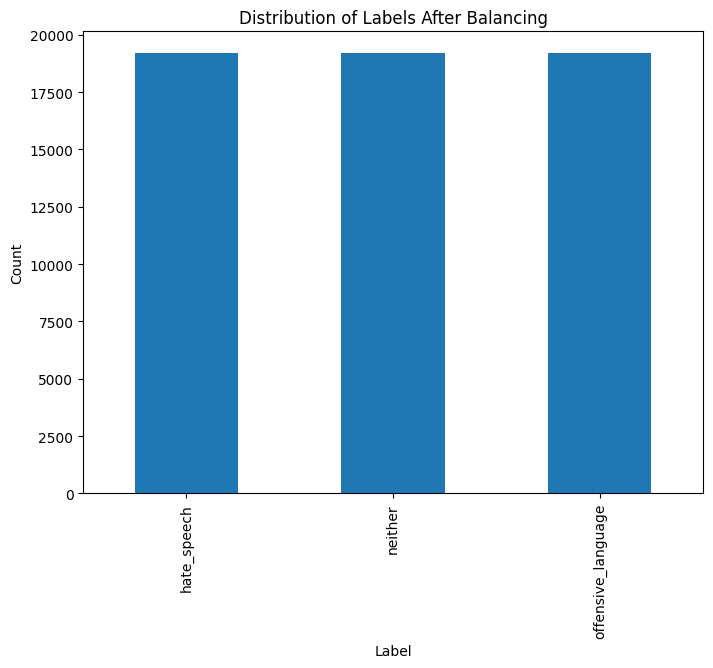

Total samples: 57570
                label                                              tweet
0         hate_speech                      rt got niggas a got bellyache
1             neither                           going free birds anyways
2         hate_speech                           fucking royal bitch work
3  offensive_language  twitter say ridin niggah really fuck pull trigger
4  offensive_language  mad cuz fucking ya enemy wins cuz letting shit...


In [ ]:
# 1) Tách theo label dạng chuỗi
df_hate = train_augmented[train_augmented['label'] == 'hate_speech']
df_off  = train_augmented[train_augmented['label'] == 'offensive_language']
df_nei  = train_augmented[train_augmented['label'] == 'neither']

# 2) Target = lớp nhiều nhất
target_count = max(len(df_hate), len(df_off), len(df_nei))
print("Target count for balancing:", target_count)

def augment_to_target(df_class, target):
    # Nếu đã >= target thì downsample về đúng target
    if len(df_class) >= target:
        return df_class.sample(n=target, replace=False, random_state=42)

    # Nếu thiếu thì oversample + augment
    need = target - len(df_class)
    seeds = df_class.sample(n=need, replace=True, random_state=42)

    augmented_rows = []
    for _, row in seeds.iterrows():
        # tạo 1 câu mới
        new_text = augment_text(row['tweet'], num_augments=1)
        new_text = new_text[0] if new_text else row['tweet']  # phòng trường hợp rỗng

        augmented_rows.append({
            'tweet': new_text,
            'label': row['label']
        })

    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df_class, augmented_df], ignore_index=True)

balanced_hate = augment_to_target(df_hate, target_count)
balanced_nei  = augment_to_target(df_nei, target_count)

# 3) Ghép lại dataset cân bằng (giữ offensive nguyên)
train_balanced = pd.concat(
    [df_off, balanced_hate, balanced_nei],
    ignore_index=True
)

# 4) Shuffle
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nFinal class distribution:")
print(train_balanced['label'].value_counts())

plt.figure(figsize=(8,6))
train_balanced['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Balancing')
plt.show()

print("Total samples:", len(train_balanced))
print(train_balanced.head())


## 8. Chuẩn bị dữ liệu đầu vào cho BERT

Sau khi cân bằng dữ liệu trên tập train, tạo các tập dữ liệu cuối cùng:
- `X_train`, `y_train` lấy từ `train_balanced`
- `X_test`, `y_test` lấy từ `test_df` (giữ nguyên dữ liệu gốc)

Đồng thời:
- Mã hóa nhãn từ dạng chuỗi sang chỉ số lớp (0–2) và one-hot (3 lớp)
- Thiết lập `max_seq_length` để chuẩn hóa độ dài chuỗi đầu vào cho BERT

**Kết quả mong đợi:** dữ liệu train/test sẵn sàng cho tokenization và huấn luyện mô hình.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train = train_balanced['tweet'].values
y_train = train_balanced['label'].values

X_test  = test_df['tweet'].values
y_test  = test_df['label'].values


y_train_encoded = to_categorical([{'hate_speech':0, 'offensive_language':1, 'neither':2}[label] for label in y_train], num_classes=3)
y_test_encoded = to_categorical([{'hate_speech':0, 'offensive_language':1, 'neither':2}[label] for label in y_test], num_classes=3)
max_seq_length = 128
print("The y train_encoded head: ")
print(y_train_encoded[:5])

The y train_encoded head: 
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


## 9. Kiểm tra kết quả tokenization (sanity check)

Trước khi huấn luyện, thực hiện một kiểm tra nhanh để đảm bảo pipeline BERT tokenization hoạt động đúng.

Ở bước này:
- Chọn một mẫu văn bản từ tập train
- Tokenize với BERT và giới hạn độ dài để dễ quan sát
- In ra:
  - Danh sách token sau khi tokenize (bao gồm `[CLS]`, `[SEP]`, `[PAD]`)
  - `input_ids` tương ứng với từng token
  - `attention_mask` để phân biệt token thật và token padding
- Trích xuất các token có `mask = 1` để xem phần nội dung thực sự được mô hình “nhìn thấy”

**Kết quả mong đợi:** tokenization hợp lý, mask đúng, không bị lỗi padding/truncation ngoài ý muốn.


In [35]:
text = X_train[0]
print("RAW TEXT:\n", text)

enc = tokenizer(
    text,
    add_special_tokens=True,
    truncation=True,
    padding="max_length",
    max_length=32,
    return_attention_mask=True,
    return_tensors="tf"
)

input_ids = enc["input_ids"][0].numpy()
attn_mask = enc["attention_mask"][0].numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids)

print("\nTOKENS:")
print(tokens)

print("\nINPUT_IDS:")
print(input_ids)

print("\nATTENTION_MASK:")
print(attn_mask)

real_tokens = [tok for tok, m in zip(tokens, attn_mask) if m == 1]
print("\nREAL TOKENS (mask=1):")
print(real_tokens)


RAW TEXT:
 heard greenish tea makes lose weight imma coon explains watermelon

TOKENS:
['[CLS]', 'heard', 'greenish', 'tea', 'makes', 'lose', 'weight', 'im', '##ma', 'co', '##on', 'explains', 'water', '##mel', '##on', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

INPUT_IDS:
[  101  2657 23753  5572  3084  4558  3635 10047  2863  2522  2239  7607
  2300 10199  2239   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]

ATTENTION_MASK:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

REAL TOKENS (mask=1):
['[CLS]', 'heard', 'greenish', 'tea', 'makes', 'lose', 'weight', 'im', '##ma', 'co', '##on', 'explains', 'water', '##mel', '##on', '[SEP]']


## 10. Khởi tạo mô hình BERT cho bài toán phân loại

Mô hình `BertForSequenceClassification` được sử dụng để giải bài toán phân loại văn bản với nhiều nhãn.

Thiết lập bao gồm:
- Tải trọng số pre-trained từ `bert-base-uncased`
- Cấu hình số lượng nhãn đầu ra phù hợp với bài toán (3 lớp)
- Khởi tạo optimizer AdamW với learning rate nhỏ để fine-tune BERT ổn định

**Kết quả mong đợi:** mô hình BERT và optimizer được khởi tạo thành công, sẵn sàng cho quá trình huấn luyện và đánh giá.


In [36]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)

print("Bert Pytorch model loaded successfully.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Pytorch model loaded successfully.


## 11. Chuẩn bị dữ liệu huấn luyện cho PyTorch (TensorDataset & DataLoader)

Để huấn luyện BERT với PyTorch, dữ liệu cần được chuyển về dạng tensor và đóng gói theo chuẩn `DataLoader`.

Các bước thực hiện:
- Tạo ánh xạ nhãn từ dạng chuỗi sang số (`label2id`) để phù hợp với mô hình phân loại
- Chuyển toàn bộ nhãn của tập train/test sang `label_ids` (kiểu `int64`)
- Tokenize dữ liệu theo batch và trả về các tensor:
  - `input_ids`
  - `attention_masks`
  - `labels`
- Đóng gói tensor thành `TensorDataset`
- Tạo `DataLoader`:
  - Train dùng `RandomSampler` để trộn dữ liệu theo batch
  - Validation dùng `SequentialSampler` để duyệt tuần tự
- In ra kích thước một batch để kiểm tra nhanh định dạng đầu vào

**Kết quả mong đợi:** `train_dataloader` và `validation_dataloader` được tạo thành công và có shape đúng chuẩn cho fine-tuning BERT.


In [37]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# 1) Map label string -> int (0/1/2)
label2id = {'hate_speech': 0, 'offensive_language': 1, 'neither': 2}

def to_label_ids(labels):
    # labels có thể là list/np array/pandas series
    labels = np.asarray(labels)
    # nếu labels là string/object -> map
    if labels.dtype == object or isinstance(labels[0], str):
        labels = np.array([label2id[x] for x in labels], dtype=np.int64)
    else:
        labels = labels.astype(np.int64)
    return labels

y_train_ids = to_label_ids(y_train)
y_test_ids  = to_label_ids(y_test)

print("y_train example:", y_train[:5])
print("y_train_ids example:", y_train_ids[:5], "dtype:", y_train_ids.dtype)

# 2) Tokenize (batch, nhanh)
def prepare_data(texts, labels_ids, tokenizer, max_length=128):
    enc = tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = enc['input_ids']
    attention_masks = enc['attention_mask']
    labels_tensor = torch.tensor(labels_ids, dtype=torch.long)
    return input_ids, attention_masks, labels_tensor

train_input_ids, train_attention_masks, train_labels = prepare_data(X_train, y_train_ids, tokenizer, max_length=128)
test_input_ids, test_attention_masks, test_labels = prepare_data(X_test, y_test_ids, tokenizer, max_length=128)

# 3) DataLoader
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset  = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

print("DataLoaders prepared.")
print("Train batch shapes (input_ids, mask, labels):",
      next(iter(train_dataloader))[0].shape,
      next(iter(train_dataloader))[1].shape,
      next(iter(train_dataloader))[2].shape)


y_train example: ['neither' 'neither' 'neither' 'neither' 'neither']
y_train_ids example: [2 2 2 2 2] dtype: int64
DataLoaders prepared.
Train batch shapes (input_ids, mask, labels): torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32])


In [38]:
from google.colab import files

## 12. Huấn luyện mô hình (Fine-tuning) với Early Stopping và lưu checkpoint tốt nhất

Phần này thực hiện quá trình fine-tune BERT trên tập dữ liệu đã chuẩn bị, đồng thời theo dõi chất lượng trên tập validation để tránh overfitting.

Các điểm chính trong quy trình huấn luyện:
- Thiết lập thư mục lưu kết quả (`checkpoints/`) và đường dẫn lưu mô hình tốt nhất
- Tự động chọn thiết bị chạy (GPU nếu có, ngược lại dùng CPU)
- Cấu hình siêu tham số huấn luyện: số epoch, batch size, learning rate và `patience` cho early stopping
- Sử dụng `AdamW` và learning rate scheduler tuyến tính để tối ưu ổn định khi fine-tune
- Vòng lặp huấn luyện theo epoch gồm:
  - `train()`: lan truyền xuôi/ngược, gradient clipping, optimizer step và scheduler step
  - `eval()`: tính validation loss và accuracy
- Lưu mô hình tốt nhất khi validation loss cải thiện theo 2 định dạng:
  - **HuggingFace folder** (`checkpoints/bert_best/`): thuận tiện load lại bằng `from_pretrained`
  - **state_dict** (`checkpoints/best_model.pt`): dạng nhẹ, linh hoạt khi tự load bằng PyTorch
- Kích hoạt early stopping khi không còn cải thiện sau `patience` epoch liên tiếp

Tùy môi trường chạy (Colab), có thể nén và lưu toàn bộ thư mục `checkpoints/` lên Google Drive để tránh mất dữ liệu sau khi runtime reset.

**Kết quả mong đợi:** mô hình tốt nhất được lưu trong `checkpoints/`, kèm theo log loss/accuracy theo từng epoch.


In [39]:
# =========================
# TRAIN + EARLY STOPPING + SAVE BEST MODEL (into a repo folder)
# - Saves BOTH: (1) HuggingFace folder (recommended) and (2) state_dict .pt
# - You can open repo folder and see: checkpoints/bert_best/  and checkpoints/best_model.pt
# =========================

import os
import numpy as np
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

# --------- 0) Where will it save? (relative to current working directory) ----------
print("Current working dir:", os.getcwd())

SAVE_DIR = "checkpoints"  # folder in your repo (or current folder)
os.makedirs(SAVE_DIR, exist_ok=True)

BEST_PT_PATH = os.path.join(SAVE_DIR, "best_model.pt")     # state_dict
BEST_HF_DIR  = os.path.join(SAVE_DIR, "bert_best")         # HF format folder
os.makedirs(BEST_HF_DIR, exist_ok=True)

# --------- 1) Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# --------- 2) Training params ----------
epochs = 10
patience = 3
best_val_loss = float("inf")
patience_counter = 0

optimizer = AdamW(model.parameters(), lr=3e-5)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

train_losses, val_losses, val_accuracies = [], [], []

# --------- 3) Training loop ----------
for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")

    # ---- Train ----
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad(set_to_none=True)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 50 == 0 and step != 0:
            print(f"  Step {step}/{len(train_dataloader)} | avg loss so far: {total_train_loss/(step+1):.4f}")

    avg_train_loss = total_train_loss / max(1, len(train_dataloader))
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # ---- Validate ----
    model.eval()
    total_eval_loss = 0.0
    total_eval_accuracy = 0.0

    for batch in tqdm(validation_dataloader, desc="Validation", leave=False):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.detach().cpu().numpy()
        batch_acc = (preds == labels).mean()
        total_eval_accuracy += batch_acc

    avg_val_loss = total_eval_loss / max(1, len(validation_dataloader))
    avg_val_acc = total_eval_accuracy / max(1, len(validation_dataloader))

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Acc : {avg_val_acc:.4f}")

    # ---- Early stopping + Save best ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

        # (A) Save HuggingFace folder (recommended)
        model.save_pretrained(BEST_HF_DIR)
        tokenizer.save_pretrained(BEST_HF_DIR)

        # (B) Save state_dict too (optional)
        torch.save(model.state_dict(), BEST_PT_PATH)

        print(f"✅ Improved! Saved to:\n - {BEST_HF_DIR}\n - {BEST_PT_PATH}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

print("\nTraining complete!")
print("Best val loss:", best_val_loss)
# --- Phần code bổ sung để lưu vào Google Drive ---
import shutil
import os
from google.colab import drive

try:
    # 1. Kết nối Drive
    print("\n--- Đang kết nối Google Drive ---")
    # force_remount=True giúp tránh lỗi nếu trước đó kết nối bị chập chờn

    # 2. Định nghĩa tên file và đường dẫn
    zip_name = "checkpoints_final" # shutil sẽ tự thêm đuôi .zip
    drive_dest = "/content/drive/MyDrive/checkpoints_final.zip"

    # 3. Nén folder checkpoints bằng Python (ổn định hơn !zip trên một số môi trường)
    print(f"Đang nén thư mục '{SAVE_DIR}'...")
    if os.path.exists(SAVE_DIR):
        shutil.make_archive(zip_name, 'zip', SAVE_DIR)

        # 4. Copy vào Google Drive
        print(f"Đang lưu vào Drive: {drive_dest}")
        shutil.copy(f"{zip_name}.zip", drive_dest)

        print("✅ THÀNH CÔNG: File đã nằm an toàn trên Google Drive của bạn.")
    else:
        print(f"❌ Lỗi: Không tìm thấy thư mục {SAVE_DIR} để nén.")

except Exception as e:
    print(f"❌ Lỗi Drive: {e}")
    print("Mẹo: Nếu VSCode không hiện bảng cấp quyền Drive, hãy mở bản web Colab để thực hiện Mount một lần.")

Current working dir: /content
Using device: cuda

======== Epoch 1 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.9244
  Step 100/1440 | avg loss so far: 0.7858
  Step 150/1440 | avg loss so far: 0.7141
  Step 200/1440 | avg loss so far: 0.6625
  Step 250/1440 | avg loss so far: 0.6289
  Step 300/1440 | avg loss so far: 0.6009
  Step 350/1440 | avg loss so far: 0.5705
  Step 400/1440 | avg loss so far: 0.5483
  Step 450/1440 | avg loss so far: 0.5326
  Step 500/1440 | avg loss so far: 0.5183
  Step 550/1440 | avg loss so far: 0.5060
  Step 600/1440 | avg loss so far: 0.4929
  Step 650/1440 | avg loss so far: 0.4818
  Step 700/1440 | avg loss so far: 0.4744
  Step 750/1440 | avg loss so far: 0.4654
  Step 800/1440 | avg loss so far: 0.4572
  Step 850/1440 | avg loss so far: 0.4490
  Step 900/1440 | avg loss so far: 0.4412
  Step 950/1440 | avg loss so far: 0.4330
  Step 1000/1440 | avg loss so far: 0.4263
  Step 1050/1440 | avg loss so far: 0.4187
  Step 1100/1440 | avg loss so far: 0.4111
  Step 1150/1440 | avg loss so far: 0.4042
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.2090
Validation Acc : 0.9298
✅ Improved! Saved to:
 - checkpoints/bert_best
 - checkpoints/best_model.pt

======== Epoch 2 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.1558
  Step 100/1440 | avg loss so far: 0.1552
  Step 150/1440 | avg loss so far: 0.1684
  Step 200/1440 | avg loss so far: 0.1713
  Step 250/1440 | avg loss so far: 0.1688
  Step 300/1440 | avg loss so far: 0.1719
  Step 350/1440 | avg loss so far: 0.1674
  Step 400/1440 | avg loss so far: 0.1694
  Step 450/1440 | avg loss so far: 0.1687
  Step 500/1440 | avg loss so far: 0.1696
  Step 550/1440 | avg loss so far: 0.1692
  Step 600/1440 | avg loss so far: 0.1672
  Step 650/1440 | avg loss so far: 0.1663
  Step 700/1440 | avg loss so far: 0.1652
  Step 750/1440 | avg loss so far: 0.1654
  Step 800/1440 | avg loss so far: 0.1652
  Step 850/1440 | avg loss so far: 0.1620
  Step 900/1440 | avg loss so far: 0.1617
  Step 950/1440 | avg loss so far: 0.1596
  Step 1000/1440 | avg loss so far: 0.1587
  Step 1050/1440 | avg loss so far: 0.1569
  Step 1100/1440 | avg loss so far: 0.1564
  Step 1150/1440 | avg loss so far: 0.1561
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1378
Validation Acc : 0.9547
✅ Improved! Saved to:
 - checkpoints/bert_best
 - checkpoints/best_model.pt

======== Epoch 3 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.0915
  Step 100/1440 | avg loss so far: 0.0897
  Step 150/1440 | avg loss so far: 0.0819
  Step 200/1440 | avg loss so far: 0.0840
  Step 250/1440 | avg loss so far: 0.0869
  Step 300/1440 | avg loss so far: 0.0873
  Step 350/1440 | avg loss so far: 0.0880
  Step 400/1440 | avg loss so far: 0.0865
  Step 450/1440 | avg loss so far: 0.0876
  Step 500/1440 | avg loss so far: 0.0865
  Step 550/1440 | avg loss so far: 0.0886
  Step 600/1440 | avg loss so far: 0.0877
  Step 650/1440 | avg loss so far: 0.0879
  Step 700/1440 | avg loss so far: 0.0869
  Step 750/1440 | avg loss so far: 0.0861
  Step 800/1440 | avg loss so far: 0.0869
  Step 850/1440 | avg loss so far: 0.0877
  Step 900/1440 | avg loss so far: 0.0867
  Step 950/1440 | avg loss so far: 0.0862
  Step 1000/1440 | avg loss so far: 0.0849
  Step 1050/1440 | avg loss so far: 0.0845
  Step 1100/1440 | avg loss so far: 0.0841
  Step 1150/1440 | avg loss so far: 0.0838
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1585
Validation Acc : 0.9613
No improvement. Patience: 1/3

======== Epoch 4 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.0488
  Step 100/1440 | avg loss so far: 0.0516
  Step 150/1440 | avg loss so far: 0.0518
  Step 200/1440 | avg loss so far: 0.0522
  Step 250/1440 | avg loss so far: 0.0510
  Step 300/1440 | avg loss so far: 0.0501
  Step 350/1440 | avg loss so far: 0.0537
  Step 400/1440 | avg loss so far: 0.0572
  Step 450/1440 | avg loss so far: 0.0560
  Step 500/1440 | avg loss so far: 0.0563
  Step 550/1440 | avg loss so far: 0.0539
  Step 600/1440 | avg loss so far: 0.0536
  Step 650/1440 | avg loss so far: 0.0538
  Step 700/1440 | avg loss so far: 0.0546
  Step 750/1440 | avg loss so far: 0.0535
  Step 800/1440 | avg loss so far: 0.0530
  Step 850/1440 | avg loss so far: 0.0530
  Step 900/1440 | avg loss so far: 0.0522
  Step 950/1440 | avg loss so far: 0.0529
  Step 1000/1440 | avg loss so far: 0.0534
  Step 1050/1440 | avg loss so far: 0.0529
  Step 1100/1440 | avg loss so far: 0.0531
  Step 1150/1440 | avg loss so far: 0.0529
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1874
Validation Acc : 0.9625
No improvement. Patience: 2/3

======== Epoch 5 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

  Step 50/1440 | avg loss so far: 0.0220
  Step 100/1440 | avg loss so far: 0.0219
  Step 150/1440 | avg loss so far: 0.0245
  Step 200/1440 | avg loss so far: 0.0243
  Step 250/1440 | avg loss so far: 0.0254
  Step 300/1440 | avg loss so far: 0.0266
  Step 350/1440 | avg loss so far: 0.0273
  Step 400/1440 | avg loss so far: 0.0281
  Step 450/1440 | avg loss so far: 0.0285
  Step 500/1440 | avg loss so far: 0.0279
  Step 550/1440 | avg loss so far: 0.0287
  Step 600/1440 | avg loss so far: 0.0280
  Step 650/1440 | avg loss so far: 0.0278
  Step 700/1440 | avg loss so far: 0.0288
  Step 750/1440 | avg loss so far: 0.0285
  Step 800/1440 | avg loss so far: 0.0283
  Step 850/1440 | avg loss so far: 0.0286
  Step 900/1440 | avg loss so far: 0.0300
  Step 950/1440 | avg loss so far: 0.0299
  Step 1000/1440 | avg loss so far: 0.0305
  Step 1050/1440 | avg loss so far: 0.0315
  Step 1100/1440 | avg loss so far: 0.0319
  Step 1150/1440 | avg loss so far: 0.0323
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

Validation Loss: 0.1620
Validation Acc : 0.9686
No improvement. Patience: 3/3
🛑 Early stopping triggered.

Training complete!
Best val loss: 0.13781968986408577

--- Đang kết nối Google Drive ---
Đang nén thư mục 'checkpoints'...
Đang lưu vào Drive: /content/drive/MyDrive/checkpoints_final.zip
✅ THÀNH CÔNG: File đã nằm an toàn trên Google Drive của bạn.


## 13. Trực quan hóa quá trình huấn luyện

Sau khi fine-tune, biểu đồ được dùng để quan sát xu hướng học của mô hình theo từng epoch nhằm đánh giá mức độ hội tụ và dấu hiệu overfitting.

Các biểu đồ bao gồm:
- **Loss Curve:** so sánh `Train Loss` và `Validation Loss` theo epoch  
  - Nếu train loss giảm mạnh nhưng val loss tăng → mô hình có thể đang overfit
  - Nếu cả hai cùng giảm và ổn định → mô hình học tốt và tổng quát hóa ổn
- **Validation Accuracy Curve:** theo dõi độ chính xác trên tập validation theo epoch  
  - Giúp nhận biết thời điểm mô hình đạt hiệu năng tốt nhất

**Kết quả mong đợi:** nhìn rõ quá trình hội tụ và chọn được checkpoint phù hợp cho suy luận.


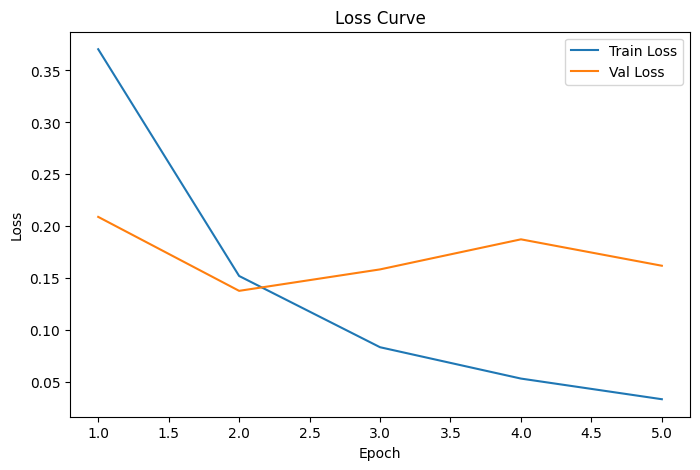

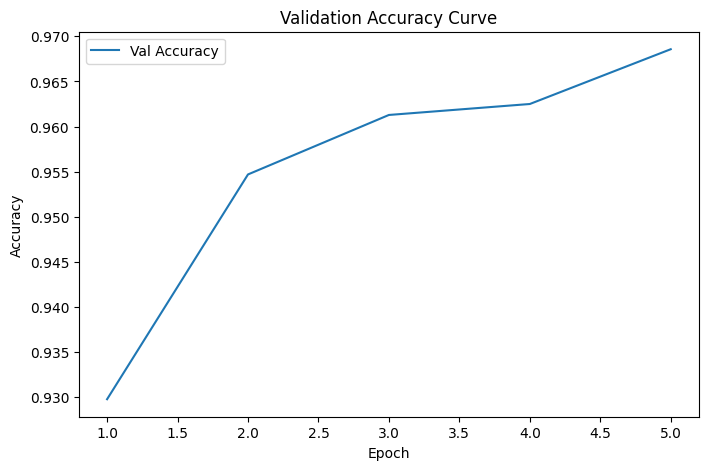

In [40]:
import matplotlib.pyplot as plt

# train_losses, val_losses, val_accuracies phải là list theo epoch
epochs_ran = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_ran, train_losses, label="Train Loss")
plt.plot(epochs_ran, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_ran, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()


In [41]:
import torch

BEST_PT_PATH = "checkpoints/best_model.pt"  # đổi đúng path bạn lưu

model.load_state_dict(torch.load(BEST_PT_PATH, map_location=device))
model.to(device)
model.eval()

print("Loaded best model from:", BEST_PT_PATH)


Loaded best model from: checkpoints/best_model.pt


In [42]:
from transformers import BertForSequenceClassification

MODEL_DIR = "checkpoints/bert_best"
model = BertForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()
print("Loaded HF model from:", MODEL_DIR)


Loaded HF model from: checkpoints/bert_best


## 14. Đánh giá mô hình bằng Classification Report và Confusion Matrix

Sau khi huấn luyện, mô hình được đánh giá chi tiết trên tập validation để hiểu rõ hiệu năng theo từng lớp.

Nội dung đánh giá gồm:
- **Classification Report**: hiển thị các chỉ số `precision`, `recall`, `f1-score` cho từng nhãn  
  - `precision`: mức độ “đúng” trong các dự đoán của một lớp  
  - `recall`: mức độ “bắt được” đúng các mẫu thuộc lớp đó  
  - `f1-score`: cân bằng giữa precision và recall, phù hợp khi dữ liệu có thể không cân bằng
- **Confusion Matrix**: trực quan hóa các trường hợp mô hình dự đoán đúng/sai giữa các lớp  
  - Giúp nhận ra mô hình thường nhầm lớp nào sang lớp nào (ví dụ: nhầm `hate_speech` thành `offensive_language`)

**Kết quả mong đợi:** có cái nhìn toàn diện về hiệu năng mô hình, không chỉ dựa vào accuracy mà còn nhìn rõ điểm mạnh/yếu theo từng nhãn.


                    precision    recall  f1-score   support

       hate_speech     0.9404    0.9706    0.9553      3838
offensive_language     0.9695    0.9109    0.9393      3838
           neither     0.9554    0.9825    0.9688      3838

          accuracy                         0.9547     11514
         macro avg     0.9551    0.9547    0.9544     11514
      weighted avg     0.9551    0.9547    0.9544     11514



<Figure size 600x600 with 0 Axes>

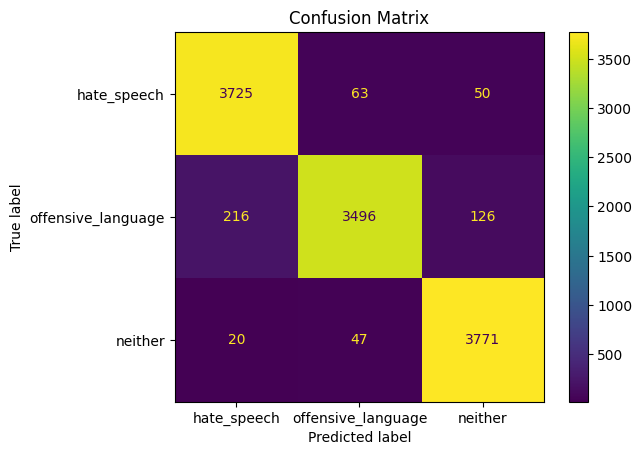

In [43]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# map id -> label (phải đúng với label2id bạn dùng khi train)
id2label = {0: "hate_speech", 1: "offensive_language", 2: "neither"}

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask
        )
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Classification report ----
target_names = [id2label[i] for i in sorted(id2label.keys())]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 6))
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [5]:
import json

path = "Bert_pipeline.ipynb"  # đúng tên file của bạn
with open(path, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

for cell in nb.get("cells", []):
    cell.get("metadata", {}).pop("widgets", None)

with open(path, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Done: removed metadata.widgets")


Done: removed metadata.widgets


## 15. Kết luận và đánh giá tổng quan

Trong đồ án này, mô hình BERT đã được fine-tune thành công cho bài toán phân loại văn bản với ba nhãn: *hate_speech*, *offensive_language* và *neither*. Kết quả đánh giá trên tập validation cho thấy mô hình đạt hiệu năng cao và ổn định.

Các điểm nổi bật:
- Độ chính xác tổng thể đạt khoảng **95.5%**, cho thấy mô hình học tốt và có khả năng tổng quát hóa cao
- F1-score của cả ba lớp đều cao và khá cân bằng:
  - *hate_speech*: F1 ≈ 0.955  
  - *offensive_language*: F1 ≈ 0.939  
  - *neither*: F1 ≈ 0.969  
- Confusion Matrix cho thấy đa số các mẫu được phân loại đúng, với số lượng lớn các dự đoán nằm trên đường chéo chính

Nhận xét chi tiết:
- Mô hình phân biệt rất tốt lớp *neither*, thể hiện qua recall và precision cao
- Một số mẫu *offensive_language* vẫn bị nhầm sang *hate_speech*, cho thấy ranh giới ngữ nghĩa giữa hai lớp này khá gần nhau
- Việc áp dụng **data augmentation** và **cân bằng dữ liệu** đã giúp cải thiện rõ rệt khả năng nhận diện lớp *hate_speech*, vốn là lớp khó và nhạy cảm

Tổng kết lại, pipeline được xây dựng đầy đủ từ tiền xử lý, cân bằng dữ liệu, fine-tuning, đánh giá cho đến trực quan hóa kết quả. Đây là một hệ thống hoàn chỉnh, có tính thực tiễn cao và phù hợp để mở rộng trong các nghiên cứu tiếp theo như:
- Áp dụng các phương pháp explainability (Integrated Gradients, Attention analysis)
- Phân tích sâu hơn các trường hợp dự đoán sai (error analysis)
- Thử nghiệm với các kiến trúc hoặc mô hình ngôn ngữ lớn hơn

Kết quả này cho thấy mô hình BERT là một lựa chọn hiệu quả cho bài toán phát hiện hate speech và offensive language trong dữ liệu văn bản ngắn.
